In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from scipy import linalg
from scipy.stats import norm

Let $\tau$ represent some time period for which we want to know the return of a stock price $(S_t)_{t \geq 0}$. We assume that $(S_t)_{t \geq 0}$ follows a geometric Brownian motion, i.e. 
$$ dS_t = \mu S_t dt + \sigma S_t dW_t,$$
where $(W_t)_{t \geq 0}$ is a Brownian motion. The explicit solution is given by
$$ S_t = S_0 \text{exp}\left( \left( \mu - \frac{\sigma^2}{2} \right)t + \sigma W_t \right).$$
Calculating $S_t/S_{t - \tau}$, we easily find for a given return $r$
\begin{align*}
    \mathbb{P}\left( \frac{S_t}{S_{t-\tau}} > r \right) &= \mathbb{P}\left( \left( \mu - \frac{\sigma^2}{2} \right)\tau + \sigma*\sqrt{\tau}X > \log(r) \right)\\
    &= \mathbb{P}\left( X > \frac{1}{\sigma*\sqrt{\tau}} \left(\log(r) + \left(\frac{\sigma^2}{2} - \mu \right)\tau\right) \right),
\end{align*}
for $X \sim \mathcal{N}(0,1)$.

In [2]:
mu = 0.0013 # drift in %
sigma = 0.036 # volatility in %
tau = 20 # number of days
r = 1.13 # return over tau days

RH = 1/(np.sqrt(tau)*sigma)*(np.log(r) + (sigma**2/2 - mu)*tau)

prob = norm.sf(RH, loc=0, scale=1)

print(prob)

0.24884304305264732


We compare the theoretical results with actual stock prices

In [3]:
ticker = "GOOG"
start_date = "2015-01-05"
end_date = "2025-01-01"

data = yf.download(tickers = ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1)) # we calculate the log returns
data.dropna(inplace=True)

# Since we have daily data, we calculate the daily drift and volatility. If we want it for a year we multiply mu by 252 and sigma by sqrt(252)
mu_data = data['log_return'].mean() # This representy the daily drift
sigma_data = data['log_return'].std()

print(mu_data, sigma_data)

0.0007992949505359027 0.017917049775535175


In [5]:
last_month_data = data[-tau:]
last_month_data['log_return_short'] = np.log(last_month_data['Close'] / last_month_data['Close'].shift(1))
last_month_data.dropna(inplace=True)

mu_last_month = last_month_data['log_return_short'].mean()
sigma_last_month = last_month_data['log_return_short'].std()

print(mu_last_month, sigma_last_month)

0.005108620264706591 0.023056524275129085


/var/folders/6b/r3xhr4d94wn52lq9yxzbnnzm0000gn/T/ipykernel_13622/2606001156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_month_data['log_return_short'] = np.log(last_month_data['Close'] / last_month_data['Close'].shift(1))
/var/folders/6b/r3xhr4d94wn52lq9yxzbnnzm0000gn/T/ipykernel_13622/2606001156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_month_data.dropna(inplace=True)


In [6]:
print(data["Close"].iloc[-1, 0]/data["Close"].iloc[0, 0])
print(last_month_data["Close"].iloc[-1, 0]/last_month_data["Close"].iloc[0, 0])

7.636027186577717
1.0827193556919543


What we can conclude is that the geometric Brownian motion model is not optimal and/or the volatility and drift neither, since the theoretical result only coincides with the observed results if the time period $\tau$ is small (where we can then assume $\mu$ and $\sigma$ constant). For larger time periods $\tau$, the results differe strongly.

In [7]:
tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "JPM", "TSLA"]

data_extended = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  6 of 6 completed


In [10]:
# First row of google stock is droped because the log returns column contains NaN
data_extended = data_extended.iloc[1:]

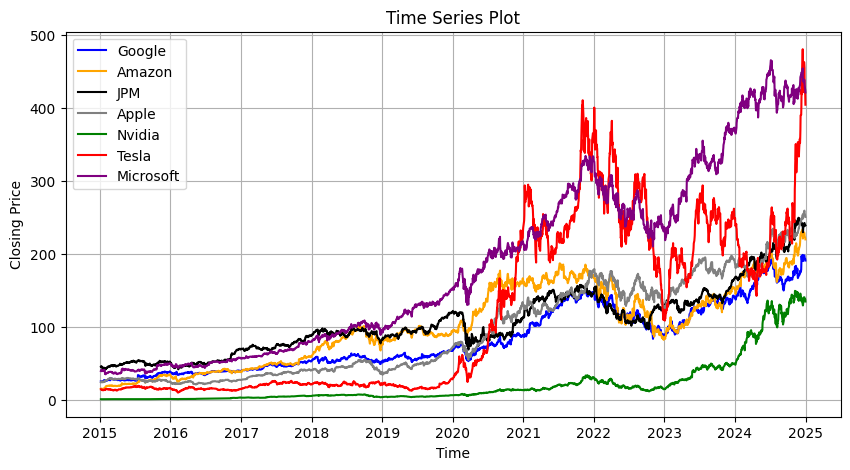

In [11]:
plt.figure(figsize=(10, 5))  
plt.plot(data.index, data['Close'], label='Google', color='blue')
plt.plot(data.index, data_extended["Close"]["AMZN"], label='Amazon', color='orange')
plt.plot(data.index, data_extended["Close"]["JPM"], label='JPM', color='black')
plt.plot(data.index, data_extended["Close"]["AAPL"], label='Apple', color='grey')
plt.plot(data.index, data_extended["Close"]["NVDA"], label='Nvidia', color='green')
plt.plot(data.index, data_extended["Close"]["TSLA"], label='Tesla', color='red')
plt.plot(data.index, data_extended["Close"]["MSFT"], label='Microsoft', color='purple')

# Formatting
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


Now we simulate the path of a geometric Brownian motion using the explicit form and the differential form.

In [41]:
timehorizon = 10 # years
timesteps = len(data.index.to_list())
initialvalue = [np.array(data["Close"].iloc[0, 0])]
S_0 = np.array([data["Close"].iloc[0, 0]])

mu_plot = 0.1
sigma_plot = 0.2

BMpath = [np.zeros(1)]
GBM_SDE = [S_0]
GBM_explicit = [S_0]

for i in range(1, timesteps):
    helper = np.random.normal(0,np.sqrt(timehorizon/timesteps),1)
    BMpath = BMpath + [BMpath[-1]+helper]
    increment = mu_plot*GBM_SDE[-1]*timehorizon/timesteps + sigma_plot*GBM_SDE[-1]*helper
    GBM_SDE = GBM_SDE + [GBM_SDE[-1] + increment]
    GBM_explicit = GBM_explicit + [S_0*np.exp((mu_plot-sigma_plot**2/2)*i*timehorizon/timesteps + sigma_plot*BMpath[-1])]


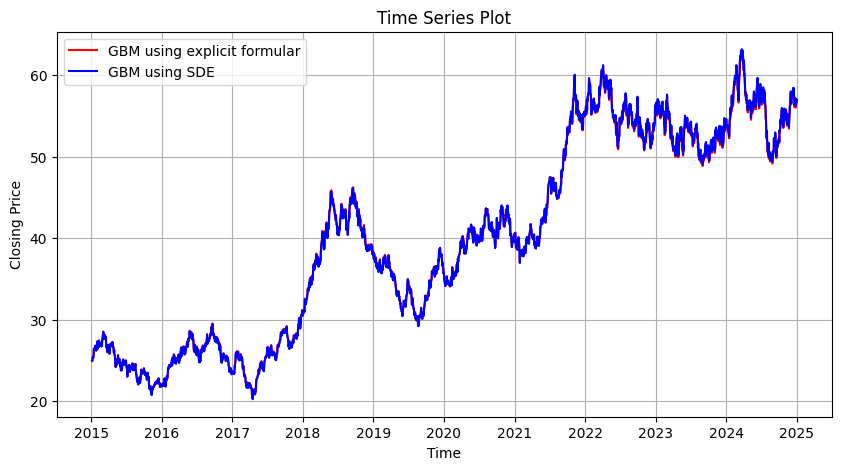

In [42]:
plt.figure(figsize=(10, 5))  
plt.plot(data.index.to_list(), GBM_explicit, label='GBM using explicit formular', color='red') # np.linspace(0, 2501, 2500)
plt.plot(data.index.to_list(), GBM_SDE, label='GBM using SDE', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

We try to recover the underlying Brownian motion from the GBM. Using the explicit description of $(S_t)_{t \geq 0}$, we get
$$ W_t = \frac{1}{\sigma} \left(\log\left( \frac{S_t}{S_0}\right) + \left(\frac{\sigma^2}{2} - \mu\right)t \right).$$

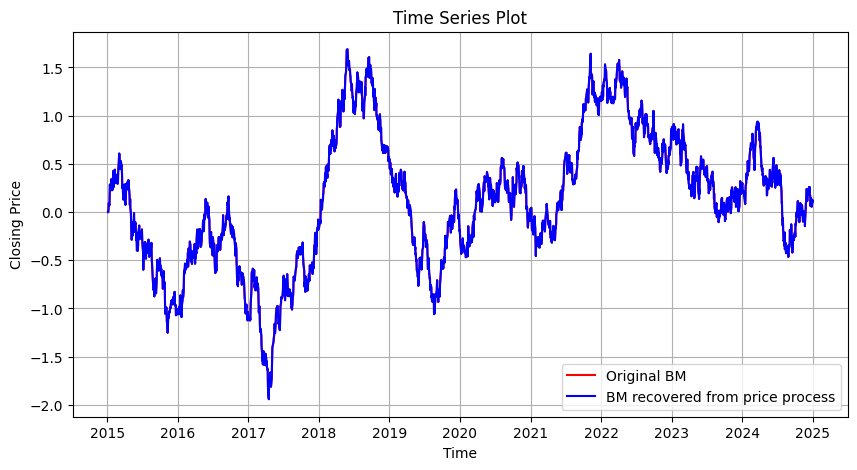

In [43]:
times = [np.array([i/timesteps*timehorizon], dtype=float) for i in range(timesteps)]
recovered_BM = 1/(sigma_plot)*(np.log(GBM_explicit/S_0) + np.array((sigma_plot**2/2 - mu_plot), dtype=float)*times)

plt.figure(figsize=(10, 5))  
plt.plot(data.index.to_list(), BMpath, label='Original BM', color='red')
plt.plot(data.index.to_list(), recovered_BM, label='BM recovered from price process', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In the following we will train a machine learning model which will learn the stochastic differential equation of some stock prices. Then we will simulate many Brownian motions and predict the corresponding prices to see if we are able to draw some conclusions.

In [78]:
# First we calculate the underlying Brownian motion of the Google stock price process. We assume to work under the Black-Scholes model,
# i.e., with a geometric Brownian motion, but with non-constant drift and volatility.

period = 15

# Calculate the volatility for 15 days periods
mu_google = (data["log_return"]
         .rolling(period)
         .mean()
         .dropna())

sigma_google = (data["log_return"]
         .rolling(period)
         .cov()
         .dropna())

mu_G = mu_google.values
sigma_G = sigma_google.values

times = np.array([np.array([i/timesteps*timehorizon], dtype=float) for i in range(timesteps - (period-1))]).reshape(-1)
BM_G = 1/(sigma_G)*(np.log(data["Close"].iloc[period - 1:].values.reshape(-1)/S_0) + np.array((sigma_G**2/2 - mu_G), dtype=float)*times)

In [73]:
print(times.shape)
print(sigma_G.shape)
print(data["Close"].iloc[period - 1:].values.shape)

(2500,)
(2500,)
(2500, 1)


In [76]:
times

array([0.00000000e+00, 3.97772474e-03, 7.95544948e-03, ...,
       9.93237868e+00, 9.93635640e+00, 9.94033413e+00])

In [79]:
BM_G

array([ 123.60866599,   65.01606369,   70.45521898, ..., 3192.34493867,
       3147.54342286, 3045.07949239])

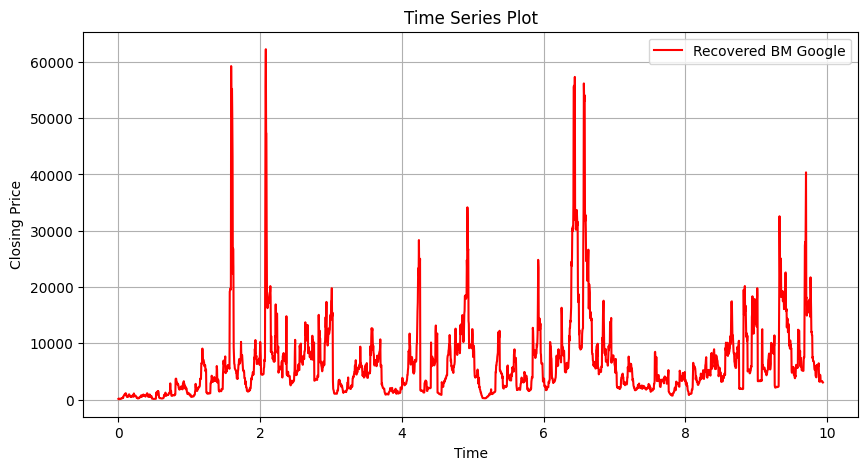

In [ ]:
plt.figure(figsize=(10, 5))  
plt.plot(times, BM_G, label='Recovered BM Google', color='red')
#plt.plot(data.index.to_list(), recovered_BM, label='BM recovered from price process', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()